In [37]:
import os
os.listdir("/kaggle/input/cars-900/cars")

['valid', 'test', 'train']

In [3]:
import warnings as w
w.filterwarnings("ignore")

In [4]:
!git clone "https://github.com/facebookresearch/detr.git"
!pip install -q cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install pytorch-lightning

Cloning into 'detr'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265 (from 1)
Receiving objects: 100% (265/265), 21.19 MiB | 32.48 MiB/s, done.
Resolving deltas: 100% (120/120), done.
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-ckkszipd
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-ckkszipd
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=376058 sha256=40606f55205f2f192fbc40111398990276487da9e37d2b52c4bb4676df8eb537
  Stored in directory: /tmp/pip-ephem-wheel-cache-kw5_bjiv/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pyco

In [6]:
import torchvision
import os

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, train=True):
        ann_file = os.path.join(img_folder, "_annotations.coco.json")
        
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)

        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension

        return pixel_values, target

In [38]:
from transformers import DetrImageProcessor

processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

train_dataset = CocoDetection(img_folder='/kaggle/input/cars-900/cars/train', processor=processor)
val_dataset = CocoDetection(img_folder='/kaggle/input/cars-900/cars/valid', processor=processor, train=False)
test_dataset = CocoDetection(img_folder='/kaggle/input/cars-900/cars/test', processor=processor, train=False)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [40]:
print("Number of training Images:", len(train_dataset))
print("Number of test Images:",len(test_dataset))
print("Number of validation Images:", len(val_dataset))

Number of training Images: 633
Number of test Images: 100
Number of validation Images: 165


# **Visualize Random Training Data**

Processing Image n°284
Processing Image n°553
Processing Image n°12


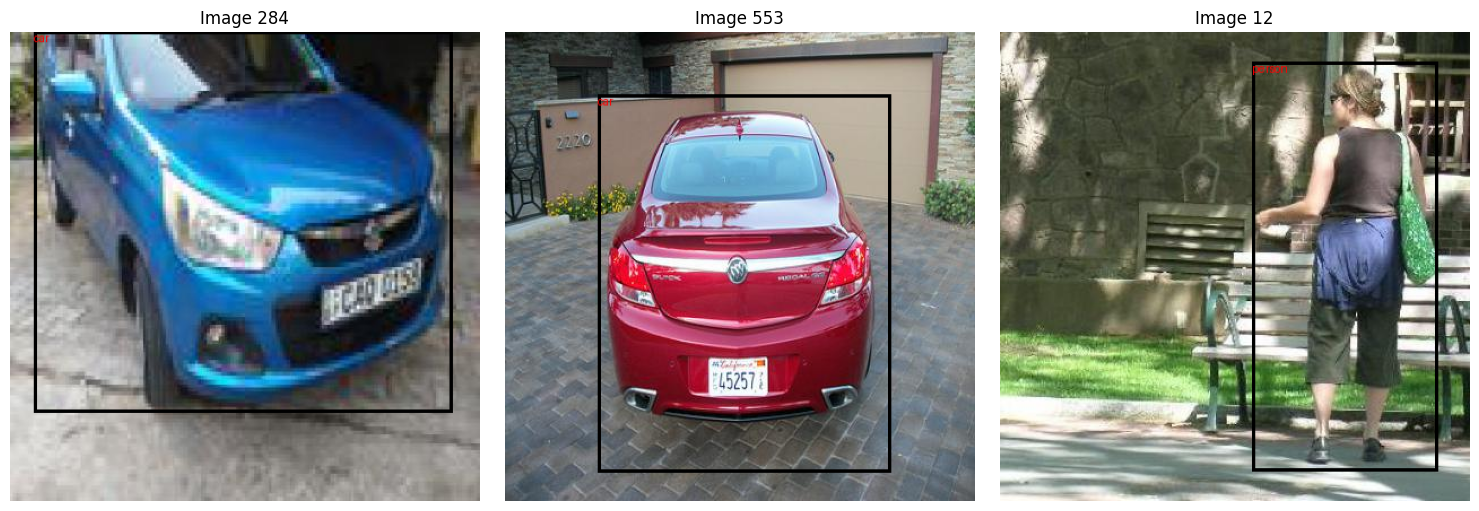

In [44]:
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

num_images = 3

# Get image IDs from dataset
image_ids = train_dataset.coco.getImgIds()

# Select three valid random image IDs
random_ids = np.random.choice(image_ids, num_images, replace=False)

# Set up the figure
fig, axes = plt.subplots(1, num_images, figsize=(5 * num_images, 5))

# Ensure axes is always iterable
if num_images == 1:
    axes = [axes]

for i, image_id in enumerate(random_ids):
    print(f'Processing Image n°{image_id}')
    image_info = train_dataset.coco.loadImgs([image_id])  # Pass list instead of single ID

    if not image_info:
        print(f"Warning: Image ID {image_id} not found.")
        continue

    image_info = image_info[0]
    image_path = os.path.join('/kaggle/input/cars-900/cars/train', image_info['file_name'])
    
    if not os.path.exists(image_path):
        print(f"Warning: Image file {image_info['file_name']} not found.")
        continue

    # Load image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image, "RGBA")

    # Get annotations
    annotations = train_dataset.coco.imgToAnns[image_id]
    
    # Get category labels
    cats = train_dataset.coco.cats
    id2label = {k: v['name'] for k, v in cats.items()}

    # Draw bounding boxes and labels
    for annotation in annotations:
        box = annotation['bbox']
        class_idx = annotation['category_id']
        x, y, w, h = tuple(box)
        draw.rectangle((x, y, x + w, y + h), outline='black', width=3)
        draw.text((x, y), id2label.get(class_idx, "Unknown"), fill='red',)

    # Display image
    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(f'Image {image_id}')

plt.tight_layout()
plt.show()

**Create the Collate Function**

In [45]:
from torch.utils.data import DataLoader

# For adding padding and masking for the transformer architecture
def collate_fn(batch):
  pixel_values = [item[0] for item in batch]
  encoding = processor.pad(pixel_values, return_tensors="pt")
  labels = [item[1] for item in batch]
  batch = {}
  batch['pixel_values'] = encoding['pixel_values']
  batch['pixel_mask'] = encoding['pixel_mask']
  batch['labels'] = labels
  return batch

train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=2)
batch = next(iter(train_dataloader))

In [46]:
batch.keys()

dict_keys(['pixel_values', 'pixel_mask', 'labels'])

In [47]:
pixel_values, target = train_dataset[0]
print(pixel_values.shape)
print(target)

torch.Size([3, 800, 800])
{'size': tensor([800, 800]), 'image_id': tensor([0]), 'class_labels': tensor([2]), 'boxes': tensor([[0.4856, 0.4892, 0.8654, 0.8774]]), 'area': tensor([485946.7500]), 'iscrowd': tensor([0]), 'orig_size': tensor([416, 416])}


In [48]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch

class Detr(pl.LightningModule):
     def __init__(self, lr, lr_backbone, weight_decay):
         super().__init__()
         # replace COCO classification head with custom head
         # we specify the "no_timm" variant here to not rely on the timm library
         # for the convolutional backbone
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             revision="no_timm",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
         self.lr = lr
         self.lr_backbone = lr_backbone
         self.weight_decay = weight_decay

     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs

     def common_step(self, batch, batch_idx):
       pixel_values = batch["pixel_values"]
       pixel_mask = batch["pixel_mask"]
       labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

       loss = outputs.loss
       loss_dict = outputs.loss_dict

       return loss, loss_dict

     def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
          self.log("train_" + k, v.item())

        return loss

     def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k,v in loss_dict.items():
          self.log("validation_" + k, v.item())

        return loss

     def configure_optimizers(self):
        param_dicts = [
              {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
              {
                  "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                  "lr": self.lr_backbone,
              },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                  weight_decay=self.weight_decay)

        return optimizer

     def train_dataloader(self):
        return train_dataloader

     def val_dataloader(self):
        return val_dataloader

In [49]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

outputs.logits.shape

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([7, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([7]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([4, 100, 7])

In [50]:
from pytorch_lightning import Trainer

trainer = Trainer(max_epochs=5, gradient_clip_val=0.1)
trainer.fit(model)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [27]:
# For Rock Paper Scissors Data on GPU T4 x2
# 1614 Training Images and 288 Validation Images took 1 hour to run 5 epochs🤦‍♂️..!
# Training Batch Size = 4
# Validation Batch Size = 2
1614*4 , 576/2

(6456, 288.0)

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
torch.save(model.state_dict(), "detr_finetuned_on_Cars.pth")

In [52]:
from IPython.display import FileLink

FileLink("detr_finetuned_on_Cars.pth")

/kaggle/working/detr_finetuned_on_Cars.pth

# **Detection Visualization**

In [65]:
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def Plot_Results(pil_img, scores, labels, boxes):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100  # Repeat colors if needed

    # Use the manually extracted labels
    id2label = {
        0: "vehicles-and-traffic-signals",
        1: "bus",
        2: "car",
        3: "person",
        4: "traffic signal",
        5: "truck"
    }

    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        label = int(label)  # Ensure it's an integer
        label_name = id2label.get(label, "Unknown")  # Get label name safely
        text = f'{label_name}: {score:0.2f}'

        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    
    plt.axis('off')
    plt.show()

def Detect_Objects_in_Image(image_path):
    # Load image
    image = Image.open(image_path).convert("RGB")
    width, height = image.size
    print(f"Image size: {width}x{height}")

    # Prepare the image for the model
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)
    
    # Perform inference
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values, pixel_mask=None)
    
    # Post-process the model outputs
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                   target_sizes=[(height, width)],
                                                                   threshold=0.5)  # Lower the threshold
    results = postprocessed_outputs[0]
    print("Model outputs:", results)

    if len(results['scores']) == 0:
        print("No objects detected.")
    else:
        Plot_Results(image, results['scores'], results['labels'], results['boxes'])

In [56]:
!wget /kaggle/working https://www.livemint.com/rf/Image-621x414/LiveMint/Period1/2012/10/01/Photos/Road621.jpg

/kaggle/working: Scheme missing.
--2025-02-23 21:18:21--  https://www.livemint.com/rf/Image-621x414/LiveMint/Period1/2012/10/01/Photos/Road621.jpg
Resolving www.livemint.com (www.livemint.com)... 23.213.186.201, 23.213.186.197, 2600:1407:7400:13::173e:2192, ...
Connecting to www.livemint.com (www.livemint.com)|23.213.186.201|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘Road621.jpg’

Road621.jpg             [ <=>                ]  50.58K  --.-KB/s    in 0.02s   

2025-02-23 21:18:22 (3.25 MB/s) - ‘Road621.jpg’ saved [51789]

FINISHED --2025-02-23 21:18:22--
Total wall clock time: 0.8s
Downloaded: 1 files, 51K in 0.02s (3.25 MB/s)


Image size: 621x414
Model outputs: {'scores': tensor([0.6883, 0.5777, 0.7680, 0.7431, 0.6775, 0.7768, 0.7999, 0.8247, 0.5268,
        0.7645, 0.8059, 0.7947, 0.7547, 0.7819, 0.6258, 0.7813],
       device='cuda:0'), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0'), 'boxes': tensor([[310.1019,  27.7221, 379.3449,  86.5212],
        [261.1416,   4.2360, 333.7586,  54.2519],
        [360.7301, 275.5484, 510.2111, 399.9795],
        [181.4923, 121.7842, 289.1080, 224.7270],
        [172.5017,  37.7885, 261.9588, 121.5302],
        [ 44.6410,  18.4708, 125.3503,  78.9798],
        [270.3223,  57.0122, 361.0991, 142.8531],
        [ 73.6347, 149.2984, 190.8754, 269.5757],
        [170.2619,  22.0247, 254.6505,  79.2142],
        [307.7768, 203.8703, 426.7045, 314.1555],
        [ 56.5574,  69.0914, 160.9161, 143.9171],
        [  9.8306, 259.4783, 140.9821, 403.9759],
        [530.1137, 290.2488, 618.3616, 405.2332],
        [358.5335, 103.8844, 472.1355, 1

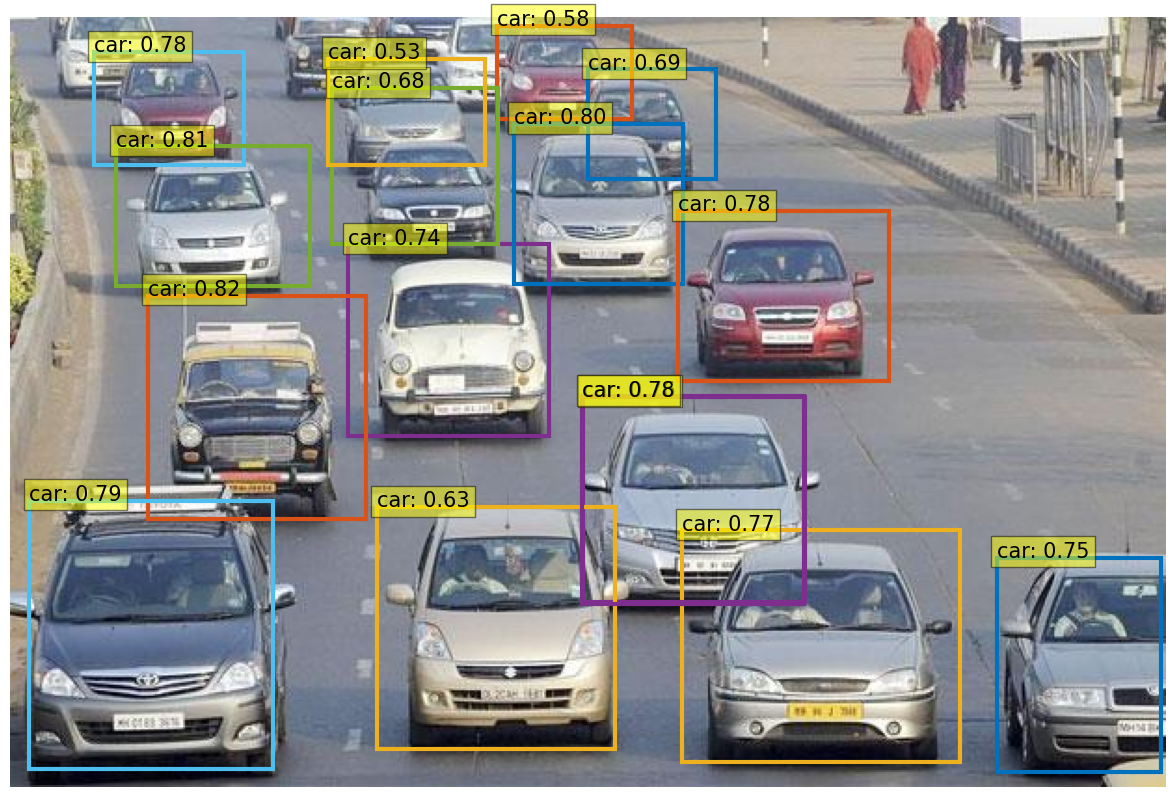

In [66]:
Detect_Objects_in_Image("/kaggle/working/Road621.jpg")